In [1]:
import numpy as np
import scipy.linalg as la
from scipy import sparse
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
from scipy.optimize import minimize,basinhopping
import cvxpy as cvx
from qutip import *
from sopt import sparse_minimize

This is a quick and inefficient MaxCut prototype using QuTiP

In [2]:
# Number of qubits
N= 4

In [3]:
# Define Operators 
def gen_cij(edge):
    i,j = edge
    Id = [qeye(2) for n in range(N)]
    si_n = tensor(Id)
    Id[i] = sigmaz()
    Id[j] = sigmaz()
    zij = tensor(Id)
    return 0.5*(si_n - zij)

def gen_B():
    b_op = 0*tensor([qeye(2) for j in range(N)])
    for i in range(N):
        Id = [qeye(2) for j in range(N)]
        Id[i] = sigmax()
        b_op += tensor(Id)
    return b_op

def gen_init():
    init = tensor([basis(2,0) for i in range(N)])
    x_all = tensor([hadamard_transform(1) for i in range(N)])
    return (x_all*init).unit()



In [4]:
ψ_init = gen_init()
edges = [[0,1],[1,2],[2,3],[3,0]]
C = np.sum(gen_cij(edge) for edge in edges)
B = gen_B()
C_vals, C_vecs = C.eigenstates()

In [5]:
def gen_U(angles):
    L = len(angles)
    γs = angles[:int(L/2)] 
    βs = angles[int(L/2):]
    U = np.prod([(-1j*βs[i]*B).expm()*(-1j*γs[i]*C).expm() for i in range(int(L/2))]) 
    return U 

In [6]:
def cost(angles,num_measures=0):
    """ The cost function of MaxCut QAOA
    
    Args:
        angles (list): The list of angles. The first half contains the γs and the second half has βs.
        num_measures (int): The number of measurement shots.

    Returns:
        float: The negative of the energy of the C expression. """
    
    
    U_temp = gen_U(angles)
    ψ_temp = U_temp*ψ_init
    if num_measures == 0:
        energy = -expect(C,ψ_temp)
    else:
        sim_counts = np.random.multinomial(num_measures,expect(ket2dm(ψ_temp),C_vecs))/num_measures 
        energy = - np.dot(C_vals,sim_counts)

    return energy

In [7]:
cost([1,2],0)

-2.8996209078634116

## Comparing some optimization routines

### Single layer

#### Nelder-Mead

In [8]:
def averaged(x): # Given a list of arrays, outputs their average and standard deviation
    # First, find the maximum length among the arrays.
    maxlength = 0
    for array in x:
        if len(array) > maxlength:
            maxlength = len(array)
    # Pad elements at the end of each arrays, so that all of them have the same length.
    for array in x:
        array += [array[-1]] * (maxlength - len(array)) 
        
    # Take the mean and standard deviation.
    mean = []
    std = []
    for i in range(maxlength):
        data = [x[j][i] for j in range(len(x))]
        mean.append(np.mean(data))
        std.append(np.std(data))
        
    return mean, std

In [9]:
num_layers = 2

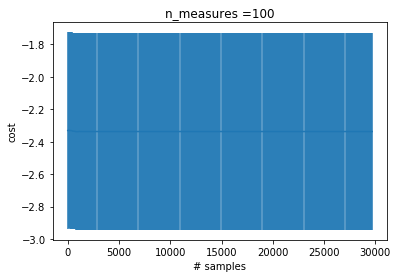

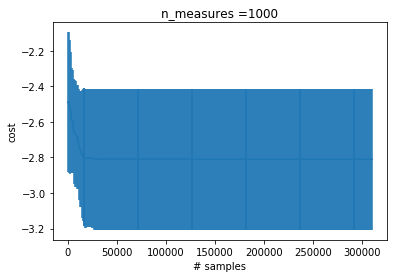

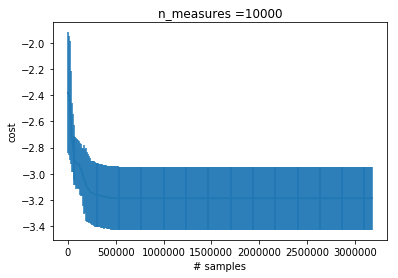

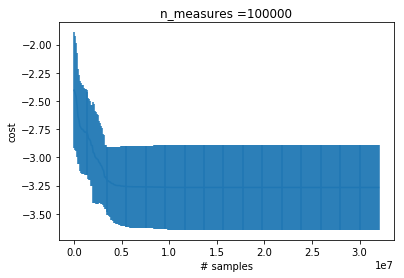

In [16]:
n_measures_list = [100,1000,10000,100000]
n_trials = 10
stats_NM = []

def callback_NM(x): # The callback function records the "noiseless" value of the cost function. 
    stats_NM_temp.append(cost(x))
    
for n_measures in n_measures_list:
    stats_NM = []
    for i in range(n_trials):
        # Initialize the history array
        stats_NM_temp = []
        # Record the data for n_trials iterations
        sol_NM = minimize(cost,np.random.rand(2*num_layers),callback=callback_NM,args = (n_measures),method='Nelder-Mead')
        #sol_NM = sparse_minimize(cost, np.random.rand(2*num_layers), cutoff=100,samples=50, args= 100)
        stats_NM.append(stats_NM_temp)
        # Take the number of average and standard deviation
        mean, std = averaged(stats_NM)
    plt.errorbar(x=[i * n_measures for i in range(len(mean))], y=mean, yerr=std)
    plt.title('n_measures ={}'.format(n_measures))
    plt.xlabel('# samples')
    plt.ylabel('cost')
    plt.show()
        

In [16]:
for i in range(n_trials):
    #plt.plot(stats_NM[i],label=f'trial #{i}')
    plt.plot(stats_NM[i])
plt.legend()
plt.xlabel('# steps')
plt.ylabel('cost');

IndexError: list index out of range

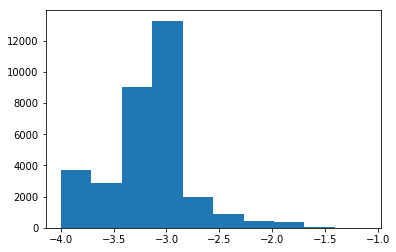

In [48]:
end = []
for i in range(len(stats_NM)):
    end.append(stats_NM[i][:-1])
a=np.hstack(end)
plt.hist(a)
plt.show()

#### Sparse Optimization.
Sparse optimization works very well!

Trial=0 which=3, cost=-4.0, x0=[4.27256601 4.0212386  2.0106193  2.136283  ]93  5.27787566]
Trial=1 which=3, cost=-3.984, x0=[4.27256601 4.0212386  3.64424748 5.27787566]8 5.27787566]
Trial=2 which=3, cost=-4.0, x0=[4.27256601 0.87964594 5.15221195 5.27787566]195 5.27787566]
Trial=3 which=3, cost=-3.94, x0=[1.13097336 0.87964594 2.0106193  3.64424748]3  2.136283  ]
Trial=4 which=3, cost=-3.9379999999999997, x0=[1.13097336 0.87964594 5.15221195 3.76991118]
Trial=5 which=3, cost=-3.93, x0=[3.76991118 1.63362818 2.38761042 0.37699112]42 0.37699112]
Trial=6 which=3, cost=-3.992, x0=[2.38761042 4.64955713 3.89557489 2.76460154]9 5.90619419]
Trial=7 which=3, cost=-3.964, x0=[4.27256601 4.1469023  0.50265482 2.136283  ]2 3.64424748]
Trial=8 which=3, cost=-3.952, x0=[1.00530965 1.00530965 2.0106193  2.136283  ]  5.27787566]
Trial=9 which=3, cost=-4.0, x0=[4.27256601 4.0212386  5.15221195 5.27787566]6]5 5.27787566]


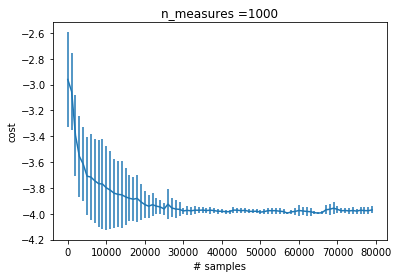

Trial=0 which=3, cost=-3.988, x0=[5.52920307 4.64955713 0.75398224 2.76460154]4 5.90619419]
Trial=1 which=3, cost=-3.9988, x0=[1.13097336 4.0212386  2.0106193  2.136283  ] 5.27787566]
Trial=2 which=3, cost=-3.9772000000000003, x0=[3.89557489 1.63362818 3.89557489 0.37699112]
Trial=3 which=3, cost=-3.9737999999999998, x0=[1.13097336 4.0212386  0.50265482 5.27787566]2]76272086e-02]
Trial=4 which=3, cost=-3.9983999999999997, x0=[4.27256601 4.0212386  2.0106193  2.136283  ]
Trial=5 which=3, cost=-3.9444, x0=[5.65486678 4.52389342 0.75398224 2.76460154] 5.90619419]
Trial=6 which=3, cost=-3.9898, x0=[0.75398224 1.63362818 2.38761042 3.51858377] 0.37699112]
Trial=7 which=3, cost=-3.9602000000000004, x0=[0.87964594 1.50796447 3.89557489 5.15221195]
Trial=8 which=3, cost=-3.9992, x0=[1.13097336 0.87964594 2.0106193  2.136283  ] 2.136283  ]
Trial=9 which=3, cost=-3.9983999999999997, x0=[4.27256601 0.87964594 2.0106193  5.27787566]


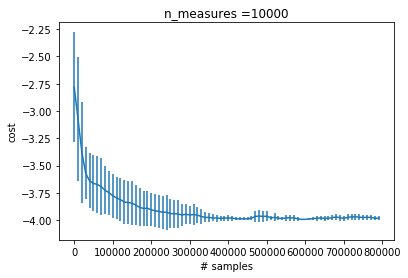

Trial=0 which=3, cost=-3.88418, x0=[4.27256601 0.87964594 5.27787566 5.27787566]5.27787566]
Trial=1 which=3, cost=-3.9985199999999996, x0=[4.27256601 4.0212386  2.0106193  5.27787566]
Trial=2 which=3, cost=-3.9983000000000004, x0=[4.27256601 4.0212386  5.15221195 2.136283  ]
Trial=3 which=3, cost=-3.9769, x0=[0.75398224 1.63362818 3.89557489 5.15221195] 5.15221195]
Trial=4 which=3, cost=-3.9988, x0=[4.27256601 0.87964594 5.15221195 2.136283  ]]5.27787566]
Trial=5 which=3, cost=-3.99138, x0=[3.89557489 1.63362818 2.38761042 0.37699112]0.37699112]
Trial=6 which=3, cost=-3.99828, x0=[1.13097336 0.87964594 2.0106193  5.27787566]5.27787566]
Trial=7 which=3, cost=-3.99868, x0=[4.27256601 4.0212386  5.15221195 2.136283  ]5.27787566]
Trial=8 which=3, cost=-3.2949599999999997, x0=[2.63893783 3.76991118 2.89026524 0.62831853]
Trial=9 which=3, cost=-3.9717200000000004, x0=[1.13097336 0.87964594 3.64424748 2.136283  ]


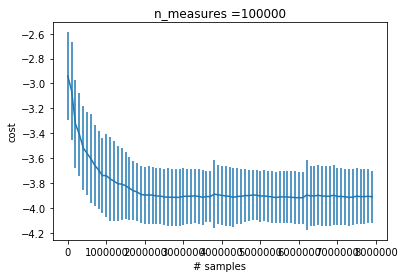

In [16]:
n_measures_list = [1000,10000,100000]
n_trials = 10
stats_so = []

    
for n_measures in n_measures_list:
    stats_so = []
    for i in range(n_trials):
        # Record the data for n_trials iterations
        x0, value, history = sparse_minimize(cost, np.random.rand(2*num_layers), cutoff=50,samples=30, args= n_measures)
        stats_so.append(history)
        # Take the number of average and standard deviation
        print("Trial={}".format(i))
    mean, std = averaged(stats_so)
    plt.errorbar(x=[i * n_measures for i in range(len(mean))], y=mean, yerr=std)
    plt.title('n_measures ={}'.format(n_measures))
    plt.xlabel('# samples')
    plt.ylabel('cost')
    plt.show()

#### BFGS

It seems that BFGS doesn't work with noise! 

In [83]:
stats_BFGS = []
n_measures = 10000

def callback_BFGS(x):
    stats_BFGS.append(cost(x))

sol_BFGS = minimize(cost,np.random.rand(2*num_layers),args = (n_measures),callback=callback_BFGS,method='BFGS')

In [84]:
sol_BFGS.x,sol_BFGS.fun #Noisy cost of the optimal solution

(array([0.16943934, 0.14162577]), -2.191)

In [85]:
cost(sol_BFGS.x,0) # Noiseless cost of the optimal solution

-2.1784099652395925

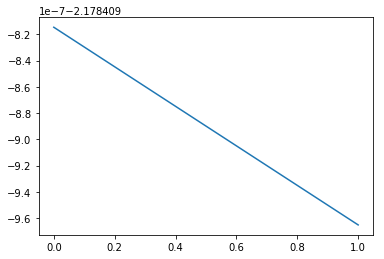

In [86]:
plt.plot(stats_BFGS)
# plt.ylim([-1,-3])

### Two layers

#### Nelder-Mead

In [40]:
num_layers = 2 

In [53]:
stats_NM = []
n_measures = 10000

def callback_NM(x): # The callback function records the "noiseless" value of the cost function. 
    stats_NM.append(cost(x))
    
sol_NM = minimize(cost,np.random.rand(2*num_layers),callback=callback_NM,args = (n_measures),method='Nelder-Mead')

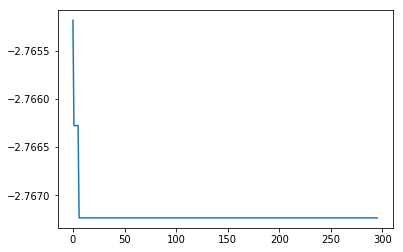

In [54]:
plt.plot(stats_NM)

In [55]:
sol_NM.x,sol_NM.fun

(array([0.5442155 , 0.3006291 , 0.06868369, 0.32935779]), -2.7998)

In [56]:
cost(sol_NM.x,0) # Noiseless cost of the optimal solution

-2.767233410961206

In [57]:
stats_BFGS = []
n_measures = 10000

def callback_BFGS(x):
    stats_BFGS.append(cost(x))

sol_BFGS = minimize(cost,np.random.rand(2*num_layers),args = (n_measures),callback=callback_BFGS,method='BFGS')

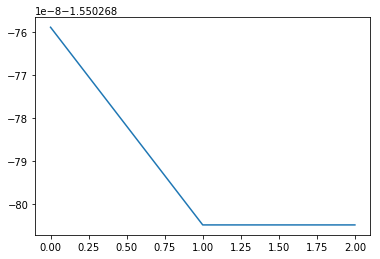

In [58]:
plt.plot(stats_BFGS)

In [59]:
sol_BFGS.x,sol_BFGS.fun

(array([0.71309047, 0.99104526, 0.91231204, 0.7920937 ]), -1.561)

In [60]:
cost(sol_BFGS.x,0) # Noiseless cost of the optimal solution

-1.550268804858805

## Comparing with Rigetti's solution

In [202]:
ψ_init = gen_init()
angle_list = [2.35394,1.18] #[γ,β]
U_mat = gen_U(angle_list)
ψ = U_mat*ψ_init 

energy = expect(C,ψ)
print(f"The optimized value is {energy}")

The optimized value is 2.9999608711896224


Plotting the wavefuntion weights

<Container object of 16 artists>

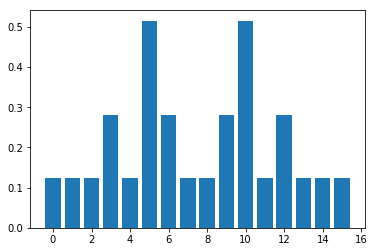

In [203]:
plt.bar(np.arange(16),np.abs(ψ.full()).flatten())